<a href="https://colab.research.google.com/github/jenelaineDC/Master-Time-Series-Analysis-Forecasting/blob/main/PROPHET/Facebook_Prophet_Demand_for_Shelter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CHALLENGE

BACKGROUND:

The `DHS Data Dashboard` provides information on individuals and families by case type, including the monthly average daily shelter census; the age and race/ethnicity of shelter clients; the monthly count of shelter subsidized and unsubsidized placements; information related to school-aged children in shelter; monthly placements for street outreach clients into transitional and permanent housing and other settings; and monthly Homebase enrollments.

GOAL:
- Predict the demand


Link: https://www.nyc.gov/site/dhs/about/stats-and-reports.page#:~:text=The%20DHS%20Data%20Dashboard%20provides%20information%20on%20individuals,housing%20and%20other%20settings;%20and%20monthly%20Homebase%20enrollments.



### SETTING UP ###

In [ ]:
# Mount Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the folder
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Modern Time Series Forecasting Techniques/CAPSTONE PROJECT_ Prophet

/content/drive/MyDrive/Python - Time Series Forecasting/Modern Time Series Forecasting Techniques/CAPSTONE PROJECT_ Prophet


In [ ]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.model_selection import ParameterGrid
import itertools

In [ ]:
# Prophet Library
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

### IMPORTING DATASET ###

In [ ]:
df = pd.read_csv('DHS_weekly.csv')
df.head()

,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
0,1/5/2014,354354,0,0,0,0.848000
1,1/12/2014,358103,0,0,0,3.257143
2,1/19/2014,359491,0,0,0,5.632857
3,1/26/2014,362880,0,0,0,-1.850000
4,2/2/2014,364125,0,0,0,1.177143


In [ ]:
# Rename column cnt to y and dteday to ds
df = df.rename(columns = {'Total Individuals in Shelter': 'y',
                          'Date': 'ds'})

# Change 'ds' into format YYYY-MM-DD
df['ds'] = pd.to_datetime(df['ds'], format = "%m/%d/%Y")
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature
0,2014-01-05,354354,0,0,0,0.848000
1,2014-01-12,358103,0,0,0,3.257143
2,2014-01-19,359491,0,0,0,5.632857
3,2014-01-26,362880,0,0,0,-1.850000
4,2014-02-02,364125,0,0,0,1.177143


### EDA ###

In [ ]:
# Create df_temp with ds as the index
df_temp = df.copy()
df_temp.set_index('ds', inplace = True)

In [ ]:
# Set the frequency of the DataFrame index to daily ("W")
df_temp.index.freq = "W"
df_temp.index

DatetimeIndex(['2014-01-05', '2014-01-12', '2014-01-19', '2014-01-26',
               '2014-02-02', '2014-02-09', '2014-02-16', '2014-02-23',
               '2014-03-02', '2014-03-09',
               ...
               '2020-11-01', '2020-11-08', '2020-11-15', '2020-11-22',
               '2020-11-29', '2020-12-06', '2020-12-13', '2020-12-20',
               '2020-12-27', '2021-01-03'],
              dtype='datetime64[ns]', name='ds', length=366, freq='W-SUN')

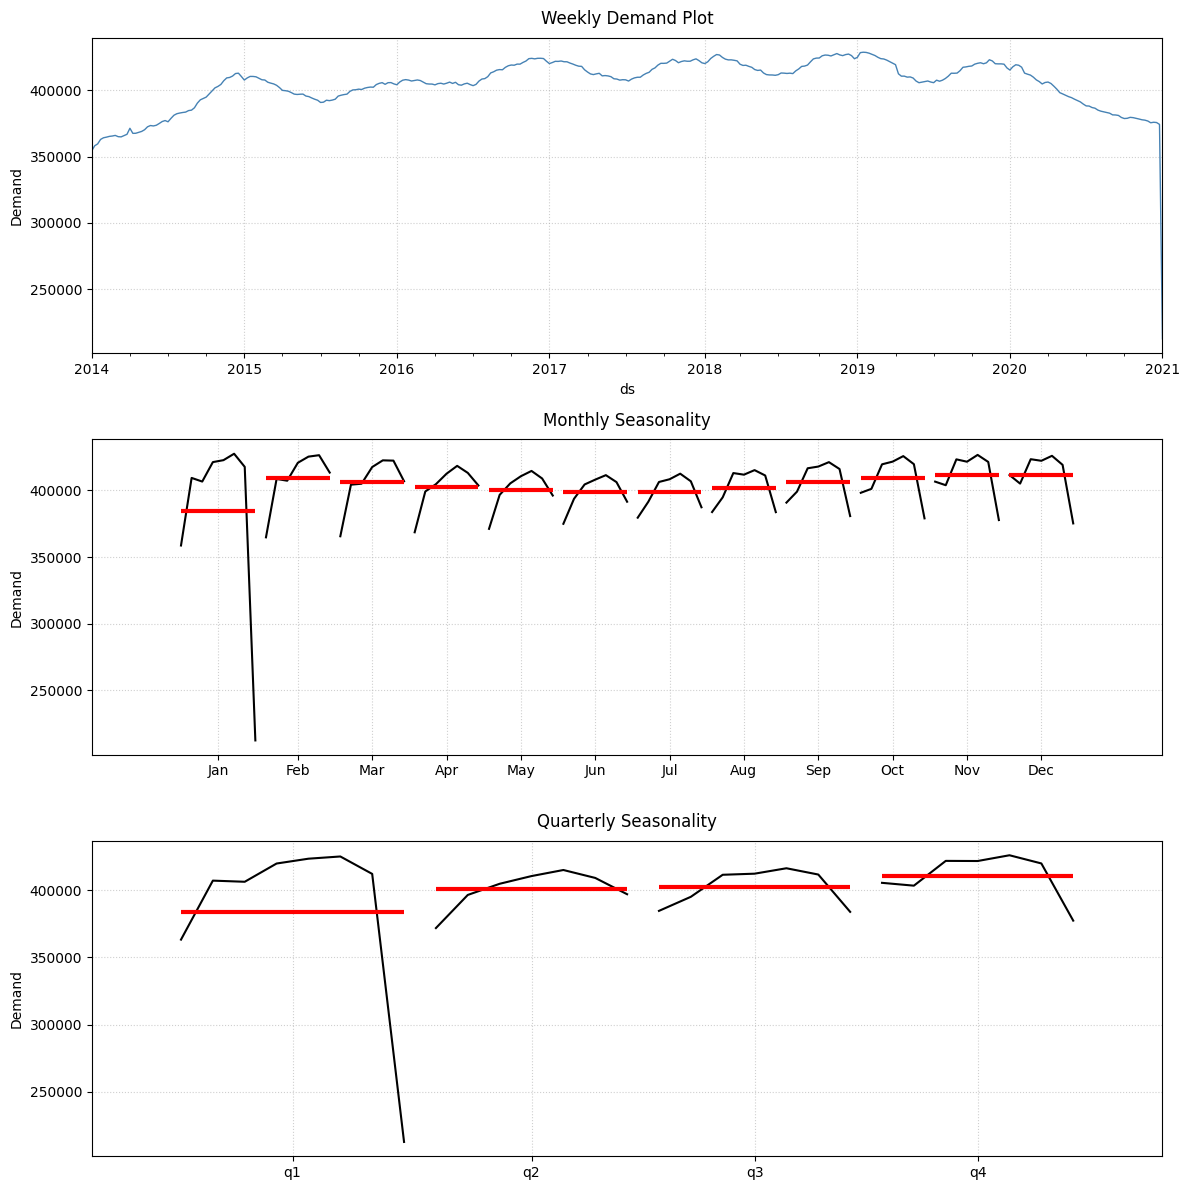

In [ ]:
# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.4)  # Adjust spacing between subplots

# Daily Plot
df_temp['y'].plot(ax=ax1, color='steelblue', linewidth=1)
ax1.set_title('Weekly Demand Plot', fontsize=12, pad=10)
ax1.set_ylabel('Demand', fontsize=10)
ax1.grid(True, linestyle=':', alpha=0.6)

# Monthly Seasonality Plot
month_plot(df_temp['y'].resample('ME').mean(), ylabel='Demand', ax=ax2)
ax2.set_title('Monthly Seasonality', fontsize=12, pad=10)
ax2.set_ylabel('Demand', fontsize=10)
ax2.grid(True, linestyle=':', alpha=0.6)

# Quarterly Seasonality Plot
quarter_plot(df_temp['y'].resample('QE').mean(), ylabel='Demand', ax=ax3)
ax3.set_title('Quarterly Seasonality', fontsize=12, pad=10)
ax3.set_ylabel('Demand', fontsize=10)
ax3.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

### Holidays

In [ ]:
df[(df['Easter'] == 1) | (df['Thanksgiving'] == 1) | (df['Christmas'] == 1)]

,ds,y,Easter,Thanksgiving,Christmas,Temperature
15,2014-04-20,367525,1,0,0,9.847143
47,2014-11-30,409590,0,1,0,9.202857
51,2014-12-28,410303,0,0,1,9.670000
65,2015-04-05,399851,1,0,0,9.235714
99,2015-11-29,405664,0,1,0,10.707143
103,2015-12-27,404725,0,0,1,14.192857
116,2016-03-27,404612,1,0,0,10.097143
151,2016-11-27,423603,0,1,0,9.007143
155,2016-12-25,421814,0,0,1,4.711429
171,2017-04-16,411752,1,0,0,14.690000


In [ ]:
holidays = pd.DataFrame()
for holiday in ['Easter', 'Thanksgiving', 'Christmas']:
  temp_holiday = pd.DataFrame({'holiday': holiday,
                               'ds': df['ds'][df[holiday] == 1],
                               'lower_window': -2,
                               'upper_window': 2})
  holidays = pd.concat([holidays, temp_holiday])

holidays

,holiday,ds,lower_window,upper_window
15,Easter,2014-04-20,-2,2
65,Easter,2015-04-05,-2,2
116,Easter,2016-03-27,-2,2
171,Easter,2017-04-16,-2,2
221,Easter,2018-04-01,-2,2
276,Easter,2019-04-21,-2,2
327,Easter,2020-04-12,-2,2
47,Thanksgiving,2014-11-30,-2,2
99,Thanksgiving,2015-11-29,-2,2
151,Thanksgiving,2016-11-27,-2,2


In [ ]:
covid_period = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.date_range(start='2019-05-26', end='2021-01-03', freq='W'),
    'lower_window': 0,
    'upper_window': 0,
})

holidays = pd.concat([holidays, covid_period])

### Train Test Split ###

In [ ]:
print(df.shape)
print(df.shape[0]*7)

(366, 6)
2562


In [ ]:
# Assuming we want to forecast 91 days into the future
train_df = df[0:353]
test_df = df[353:]

In [ ]:
print(train_df.shape)
print(test_df.shape)

(353, 6)
(13, 6)


### Building Prophet Model

In [ ]:
# Building the Prophet model
m = Prophet(
    yearly_seasonality=True,     # Include yearly seasonality
    weekly_seasonality=False,     # Include weekly seasonality
    daily_seasonality=False,
    holidays=holidays,           # Include holiday effects
    seasonality_mode="additive",
    seasonality_prior_scale=10,  # Increase flexibility of seasonality
    holidays_prior_scale=10,     # Increase impact of holidays
    changepoint_prior_scale=0.05 # Control flexibility in detecting trend changes
)

# Include holidays that might affect weekly patterns
m.add_country_holidays('US')

# Add additional regressors (external factors) to the model
m.add_regressor("Temperature")    # Whether it's a working day

# Add Monthly Seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)


m.fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpg5j7lrme/iazrbtzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg5j7lrme/5cn9vi_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3993', 'data', 'file=/tmp/tmpg5j7lrme/iazrbtzc.json', 'init=/tmp/tmpg5j7lrme/5cn9vi_j.json', 'output', 'file=/tmp/tmpg5j7lrme/prophet_modelev57xclt/prophet_model-20250819141436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:14:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:14:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


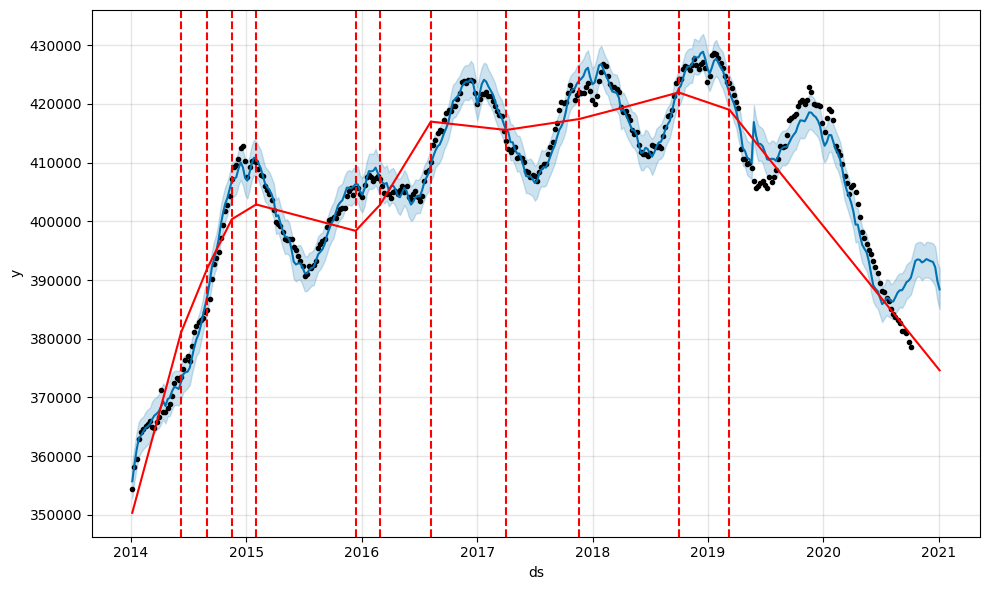

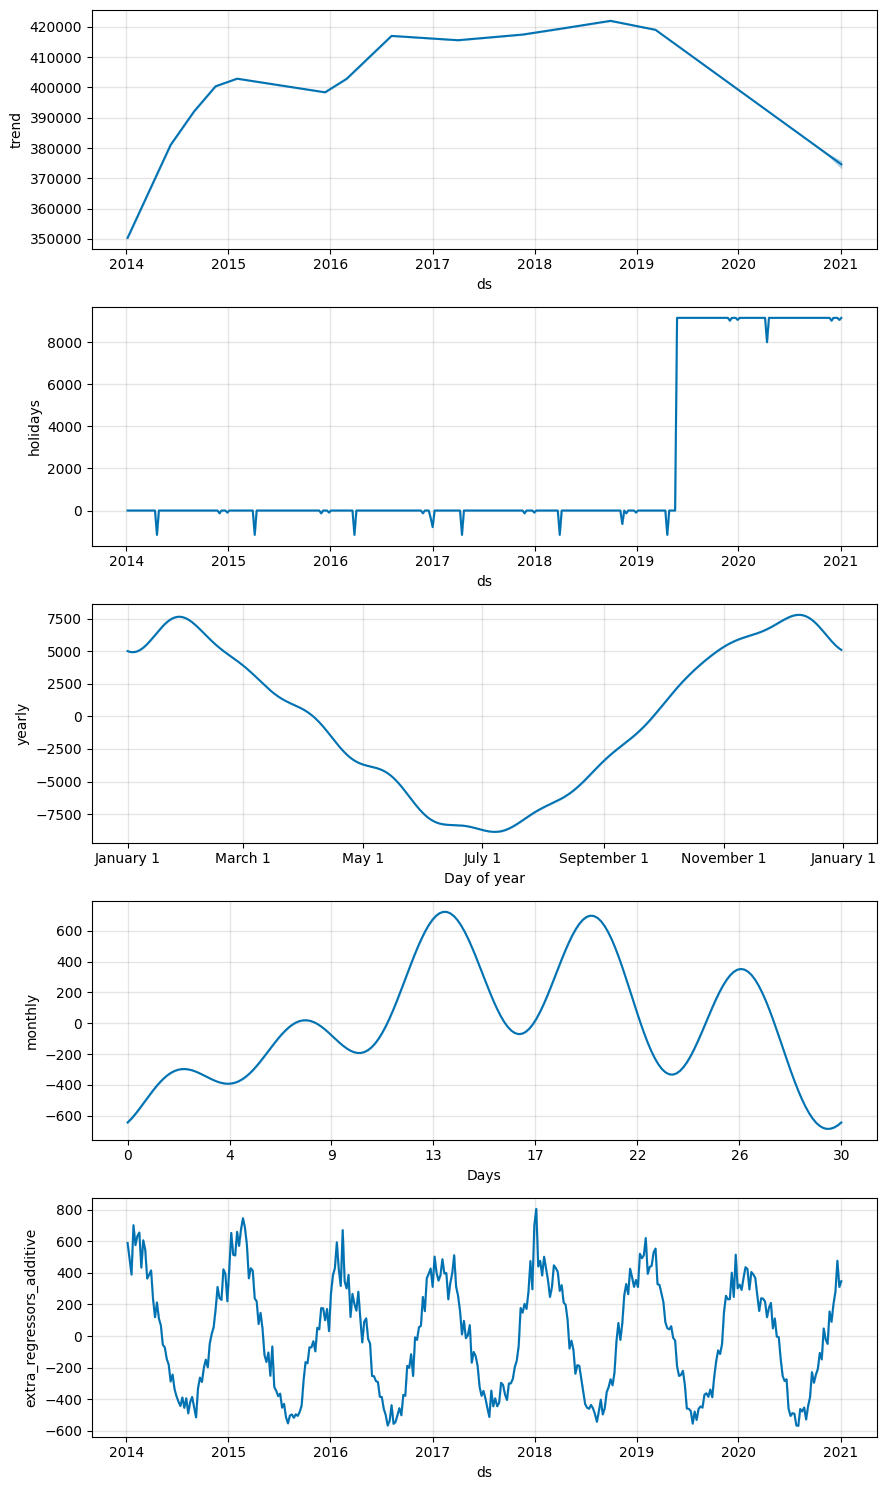

In [ ]:
# Create a dataframe for predictions
future = m.make_future_dataframe(periods=13, freq='W')  # Generate future dates for 13 weeks

# Include the regressors in the future dataframe
future = future.merge(df[['ds', 'Temperature']], on='ds', how='left')

# Predict over the future dataframe
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
fig = m.plot_components(forecast)

In [ ]:
# Evaluate predictions

forecast.set_index('ds', inplace=True)  # Set the index of forecast to 'ds' (date)
forecast = forecast.join(test_df['y'])  # Join the actual 'y' values from the test set to the forecast dataframe

# Calculate mean absolute error
forecast['error'] = (forecast['y'] - forecast['yhat']).abs()  # Calculate the absolute error between actual and predicted values
mae = forecast['error'].mean()  # Calculate the mean of the absolute errors
print(f"Mean Absolute Error: {mae}")  # Print the Mean Absolute Error

Mean Absolute Error: 27821.923604697335


### Cross Validation and Hyper Parameter Tuning ###

In [ ]:
period = '42 days'      # Step size between cutoff dates: 42 days or 6 weeks
initial = '1500 days'    # Size of initial training period
horizon = '91 days'     # Forecast horizon: 91 days or 13 weeks

In [ ]:
# Define the parameter grid to search
param_grid = {
    'changepoint_prior_scale': [0.001, 0.05, 0.5],
    'seasonality_prior_scale': [10, 20],
    'holidays_prior_scale': [10, 20],
    'seasonality_mode' : ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(model = m, period = period, initial = initial, horizon = horizon, parallel = 'processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95245', 'data', 'file=/tmp/tmpg5j7lrme/plg5l8gh.json', 'init=/tmp/tmpg5j7lrme/suuo1_jl.json', 'output', 'file=/tmp/tmpg5j7lrme/prophet_modelk3h1y90k/prophet_model-20250819140401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:04:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:04:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg5j7lrme/6rc63iec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg5j7lrme/8iycpsck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11232', 'data

In [ ]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,rmse
0,0.001,10,10,additive,18767.174493
1,0.001,10,10,multiplicative,18869.808403
2,0.001,10,20,additive,18767.174493
3,0.001,10,20,multiplicative,18869.808403
4,0.001,20,10,additive,18720.588397
5,0.001,20,10,multiplicative,18900.760686
6,0.001,20,20,additive,18720.588397
7,0.001,20,20,multiplicative,18900.760686
8,0.050,10,10,additive,5390.102422
9,0.050,10,10,multiplicative,5380.477854


In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive'}


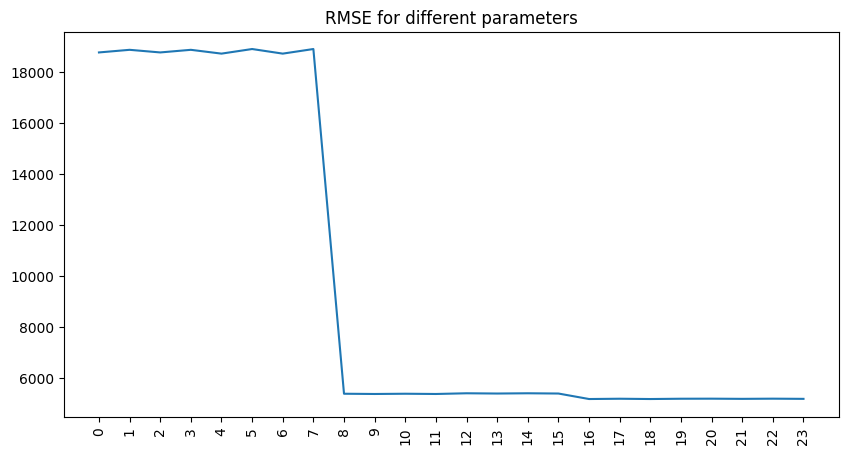

In [ ]:
# plotting the mape for the different parameters
plt.figure(figsize=(10, 5))
plt.plot(tuning_results['rmse'])
plt.xticks(range(len(tuning_results)), tuning_results.index, rotation=90)
plt.title('RMSE for different parameters')
plt.show()

In [ ]:
# Compute the Error / deviation
df_cv['deviation'] = df_cv['yhat'] - df_cv['y']
df_cv['deviation_%'] = (df_cv['yhat'] / df_cv['y'] - 1) *100
# Dates with the highest percentage deviation
df_cv.sort_values(by = 'deviation_%', ascending = False).head(20)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,deviation_%
272,2020-10-04,403776.104530,399228.189432,408218.702299,378631,2020-07-05,25145.104530,6.641058
271,2020-09-27,403078.004157,399203.618783,406881.819639,379435,2020-07-05,23643.004157,6.231108
270,2020-09-20,401999.637090,398840.741504,405315.962619,380963,2020-07-05,21036.637090,5.521963
269,2020-09-13,400832.689651,398069.369756,403657.585875,381309,2020-07-05,19523.689651,5.120175
268,2020-09-06,399780.301497,397326.768549,402260.262513,381387,2020-07-05,18393.301497,4.822740
267,2020-08-30,398778.634401,396558.011284,401104.311090,382654,2020-07-05,16124.634401,4.213894
259,2020-08-23,398818.106669,394530.805871,403033.118125,383136,2020-05-24,15682.106669,4.093091
266,2020-08-23,397693.721726,395663.263240,399937.426654,383136,2020-07-05,14557.721726,3.799623
258,2020-08-16,397781.066731,394007.709479,401380.181799,383695,2020-05-24,14086.066731,3.671162
265,2020-08-16,396570.527853,394681.285167,398424.217011,383695,2020-07-05,12875.527853,3.355667
